This notebook takes the models created by `4_Using_BERT_on_FEVER_with_Trainer_3_Classes_DATASET_V2` and applies them to the FEVER challenge dataset, in order to test their application in detecting evidence support. 

Reminder: These models relies on the data from `3_fever_processing_for_textual_entailment.ipynb`, which tries to improve on the last version of the data (v1) by changing how we choose the claim-evidence pairings. There is still more we could improve, but let's test it as it is now and see if it's enough.

In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import torch

HOME = Path('/users/k2031554')
KERNELGAT_DATA = HOME / 'Repos/KernelGAT/data'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
MAX_LEN = 300 # As defined when the tokenizer/model was fine-tuned
# MAX_LEN of 300 or 400 do not make much of a difference to metrics, so varying this based on data available is ok

# Load data and models

We begin with the **DEV** dataset (this section can be changed to look at Train, Eval, and Test datasets too by just changing the loaded dataset path), as this we can score locally. The TEST dataset needs to be sent to CodaLab.

Remember that Train and Dev all have golden data evidence added to it. This guarantees that the right evidence is on the data and *will be considered by the textual entailment model*, but should ideally not give the model any clues as to the right label. We can test this model with the Eval (Dev without golden data) to measure this influence. 

First we retrieve the data with evidence sentences already scored.\
We will combine these with the textual entailment model and get the final evidence+label predictions to get FEVER-scored.

In [2]:
df_with_evidence_scored = []
with open(KERNELGAT_DATA / 'bert_dev_from_fresh_trained_with_batch_size_32.json','r') as f:
    #This was the best performing file on evidence selection
    for line in f:
        df_with_evidence_scored.append(json.loads(line))
df_with_evidence_scored = pd.DataFrame(df_with_evidence_scored)
df_with_evidence_scored

,id,evidence,claim,label
0,91198,"[[Colin_Kaepernick, 6, He remained the team 's...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO
1,194462,"[[Tilda_Swinton, 0, Katherine Matilda `` Tilda...",Tilda Swinton is a vegan.,NOT ENOUGH INFO
2,137334,"[[Soul_Food_-LRB-film-RRB-, 0, Soul Food is a ...",Fox 2000 Pictures released the film Soul Food.,SUPPORTS
3,166626,"[[Anne_Rice, 5, Born in New Orleans , Rice spe...",Anne Rice was born in New Jersey.,NOT ENOUGH INFO
4,111897,"[[Telemundo, 0, Telemundo LRB LSB teleˈmundo R...",Telemundo is a English-language television net...,REFUTES
...,...,...,...,...
19993,8538,"[[Hermit_crab, 0, Hermit crabs are decapod cru...",Hermit crabs are arachnids.,REFUTES
19994,145641,"[[Michael_Hutchence, 15, On the morning of 22 ...",Michael Hutchence died on a boat.,REFUTES
19995,87517,"[[Cyclades, 0, The Cyclades LRB LSB ˈsɪklədiːz...",The Cyclades are located to the southeast of G...,SUPPORTS
19996,111816,"[[Theresa_May, 6, From 1977 until 1983 , she w...",Theresa May worked the docks.,NOT ENOUGH INFO


In [3]:
from transformers import BertTokenizer, BertForSequenceClassification

support_prediction_tokenizer = BertTokenizer.from_pretrained(
    './models/BERT_FEVER_v4_tok_ASHA'#_SPECIAL_CHARS_CODED'
)
support_prediction_model = BertForSequenceClassification.from_pretrained(
    './models/BERT_FEVER_v4_model_ASHA'#_SPECIAL_CHARS_CODED'
)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Evaluate and record predictions

In [5]:
df_exploded = df_with_evidence_scored.copy()
df_exploded = df_exploded.explode('evidence')
df_exploded = df_exploded[df_exploded['evidence'].apply(lambda x: type(x)==list)]
df_exploded[['evidence_page','evidence_line','evidence_text','evidence_score']] =\
    pd.DataFrame(df_exploded.evidence.tolist(), index=df_exploded.index)
df_exploded['evidence_score'] = df_exploded['evidence_score'].apply(lambda x: np.max([x,0]))
df_exploded

,id,evidence,claim,label,evidence_page,evidence_line,evidence_text,evidence_score
0,91198,"[Colin_Kaepernick, 6, He remained the team 's ...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,6,He remained the team 's starting quarterback f...,0.999393
0,91198,"[Colin_Kaepernick, 0, Colin Rand Kaepernick LR...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,0,Colin Rand Kaepernick LRB LSB ` kæpərnɪk RSB ;...,0.260226
0,91198,"[Colin_Kaepernick, 2, Kaepernick was selected ...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,2,Kaepernick was selected by the San Francisco 4...,0.000000
0,91198,"[Colin_Kaepernick, 8, In the following seasons...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,8,"In the following seasons , Kaepernick lost and...",0.000000
0,91198,"[Colin_Kaepernick, 7, During the 2013 season ,...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,7,"During the 2013 season , his first full season...",0.000000
...,...,...,...,...,...,...,...,...
19997,81957,"[Trouble_with_the_Curve, 2, Filming began in M...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,2,"Filming began in March 2012 , and the film was...",1.000000
19997,81957,"[Trouble_with_the_Curve, 0, Trouble with the C...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,0,Trouble with the Curve is a 2012 sports drama ...,1.000000
19997,81957,"[Trouble_with_the_Curve, 5, This was Eastwood ...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,5,This was Eastwood 's first acting project sinc...,1.000000
19997,81957,"[Trouble_with_the_Curve, 6, A year after its r...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,6,A year after its release the film became the s...,0.404244


In [6]:
import re
def process_sent(sentence):
    sentence = re.sub("LSB.*?RSB", "", sentence)
    sentence = re.sub("LRB RRB ", "", sentence)
    sentence = re.sub("LRB", " ( ", sentence)
    sentence = re.sub("RRB", " )", sentence)
    sentence = re.sub("--", "-", sentence)
    sentence = re.sub("``", '"', sentence)
    sentence = re.sub("''", '"', sentence)

    return sentence

def process_wiki_title(title):
    title = re.sub("_", " ", title)
    title = re.sub(" -LRB-", " ( ", title)
    title = re.sub("-RRB-", " )", title)
    title = re.sub("-COLON-", ":", title)
    return title

df_exploded['evidence_page'] =\
    df_exploded['evidence_page'].apply(process_wiki_title)

df_exploded['evidence_text'] =\
    df_exploded['evidence_text'].apply(process_sent)

In [7]:
encoding_inputs = df_exploded.apply(lambda x : [x['claim'],x['evidence_text']], axis=1).to_list()
# This creates a bug list of (claim, evidence) pairs
encodings = support_prediction_tokenizer(
        encoding_inputs,
        max_length= MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
    ).to(DEVICE)

In [8]:
import torch

BATCH_SIZE = 64
support_prediction_model.to(DEVICE)
support_prediction_model.eval()
probs_all = []

total_steps = len(encodings['input_ids'])//BATCH_SIZE + 1
with torch.no_grad():
    for i in range(total_steps):
        print(str(round(100*i/total_steps, 5)).ljust(10,' '),'%', end='\r')
        probs = support_prediction_model(
            input_ids=encodings['input_ids'][i*BATCH_SIZE:(i+1)*BATCH_SIZE],
            attention_mask=encodings['attention_mask'][i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        )
        probs_all = probs_all + torch.softmax(probs.logits,dim=1).tolist()

In [62]:
assert len(probs_all) == df_exploded.shape[0]

In [63]:
df_exploded['predicted_scores'] = probs_all
df_exploded['weighted_scores'] = df_exploded.apply(
    lambda x: x['evidence_score'] * np.array(x['predicted_scores']),
    axis = 1
)

In [64]:
#df_exploded.to_csv('./data/support_data_v2/bert_test_from_fresh_trained_with_batch_size_32_with_support_scores_v2.csv', index=None)

In [173]:
df_exploded

,id,evidence,claim,label,evidence_page,evidence_line,evidence_text,evidence_score,predicted_scores,weighted_scores
0,91198,"[Colin_Kaepernick, 6, He remained the team 's ...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin Kaepernick,6,He remained the team 's starting quarterback f...,0.999393,"[0.6890734434127808, 0.14342443645000458, 0.16...","[0.6886551663906744, 0.1433373758518215, 0.167..."
0,91198,"[Colin_Kaepernick, 0, Colin Rand Kaepernick LR...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin Kaepernick,0,"Colin Rand Kaepernick ( ; born November 3 ,...",0.260226,"[0.09081129729747772, 0.06759993731975555, 0.8...","[0.02363147250009412, 0.017591270109784674, 0...."
0,91198,"[Colin_Kaepernick, 2, Kaepernick was selected ...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin Kaepernick,2,Kaepernick was selected by the San Francisco 4...,0.000000,"[0.15698134899139404, 0.0928133875131607, 0.75...","[0.0, 0.0, 0.0]"
0,91198,"[Colin_Kaepernick, 8, In the following seasons...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin Kaepernick,8,"In the following seasons , Kaepernick lost and...",0.000000,"[0.39150694012641907, 0.09691359102725983, 0.5...","[0.0, 0.0, 0.0]"
0,91198,"[Colin_Kaepernick, 7, During the 2013 season ,...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin Kaepernick,7,"During the 2013 season , his first full season...",0.000000,"[0.46966177225112915, 0.11608976125717163, 0.4...","[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...
19997,81957,"[Trouble_with_the_Curve, 2, Filming began in M...",Trouble with the Curve is a television show.,REFUTES,Trouble with the Curve,2,"Filming began in March 2012 , and the film was...",1.000000,"[0.00789398793131113, 0.8767555952072144, 0.11...","[0.00789398793131113, 0.8767555952072144, 0.11..."
19997,81957,"[Trouble_with_the_Curve, 0, Trouble with the C...",Trouble with the Curve is a television show.,REFUTES,Trouble with the Curve,0,Trouble with the Curve is a 2012 sports drama ...,1.000000,"[0.007430511061102152, 0.8966994285583496, 0.0...","[0.007430511061102152, 0.8966994285583496, 0.0..."
19997,81957,"[Trouble_with_the_Curve, 5, This was Eastwood ...",Trouble with the Curve is a television show.,REFUTES,Trouble with the Curve,5,This was Eastwood 's first acting project sinc...,1.000000,"[0.007505549117922783, 0.8948820233345032, 0.0...","[0.007505549117922783, 0.8948820233345032, 0.0..."
19997,81957,"[Trouble_with_the_Curve, 6, A year after its r...",Trouble with the Curve is a television show.,REFUTES,Trouble with the Curve,6,A year after its release the film became the s...,0.404244,"[0.0074891638942062855, 0.8857460021972656, 0....","[0.003027447826232793, 0.35805730076504005, 0...."


In [238]:
support_classes = ['SUPPORTS','REFUTES','NOT ENOUGH INFO']

methods = ['WEIGHTED_SUM', 'WEIGHTED_SUM2', 'MALON', 'RANKED']

def get_label(s):
    if all(s==0):
        return 2
    else:
        return np.argmax(s)    

In [239]:
if 'WEIGHTED_SUM' in methods:
    predicted_labels = []
    
    for idx in df_with_evidence_scored.index:
        try:
            weighted_scores = df_exploded.weighted_scores.loc[idx]
            if type(weighted_scores) == np.ndarray:#In this case, there is only one evidence
                # cast it to be like the others
                weighted_scores = pd.Series([weighted_scores], index=[idx])
                
            summed_scores = weighted_scores.sum()
            assert type(summed_scores) == np.ndarray
            
            if all(summed_scores == 0):
                predicted_labels.append('NOT ENOUGH INFO')
            else:
                predicted_labels.append(support_classes[np.argmax(summed_scores)])
                
        except KeyError: #no evidence selected for this claim
            predicted_labels.append('NOT ENOUGH INFO')
            
    df_with_evidence_scored['predicted_label_WEIGHTED_SUM'] = predicted_labels

In [240]:
if 'WEIGHTED_SUM2' in methods:
    predicted_labels = []
    for idx in df_with_evidence_scored.index:
        try:
            weighted_scores = df_exploded.weighted_scores.loc[idx]
            if type(weighted_scores) == np.ndarray:#In this case, there is only one evidence
                # cast it to be like the others
                weighted_scores = pd.Series([weighted_scores], index=[idx])
                
            weighted_labels = [get_label(s) for s in weighted_scores ]
            weighted_scores_with_labels = list(zip(weighted_scores, weighted_labels))
            
            if 0 not in weighted_labels and 1 not in weighted_labels:
                predicted_labels.append('NOT ENOUGH INFO')
            else:
                summed_scores = sum([e[0] for e in weighted_scores_with_labels if e[1] != 2])
                summed_scores[2] = 0
                predicted_labels.append(support_classes[np.argmax(summed_scores)])
        except KeyError:
            predicted_labels.append('NOT ENOUGH INFO')
            
    df_with_evidence_scored['predicted_label_WEIGHTED_SUM2'] = predicted_labels

In [241]:
if 'MALON' in methods:
    '''
     Like (Malon, 2018), the default label is ’NOT ENOUGH INFO’ unless there is any supporting evidence to
     predict the claim label as ’SUPPORTED’. If there is at least one piece of evidence rejecting the claim
     while there is no supporting evidence, the final decision is ’REFUTED’.
     '''
    predicted_labels = []
    for idx in df_with_evidence_scored.index:
        try:
            individual_scores = []             
                
            if type(df_exploded.weighted_scores[idx]) == np.ndarray:#only one evidence means a single ndarray
                scores_list = [df_exploded.weighted_scores[idx]]
            else:
                scores_list = df_exploded.weighted_scores[idx].to_list()#otherwise a series of ndarrays
                
            # now scores_list is a list of ndarrays regardless
            for scores in scores_list:
                if all(scores == 0):#zero for all three classes means no classification was done for lack of evidence
                    individual_scores.append(2)
                else:
                    individual_scores.append(np.argmax(scores))
                    
            if 1 not in individual_scores and 0 not in individual_scores:
                predicted_labels.append('NOT ENOUGH INFO')
            #elif 1 in individual_scores:
            elif 1 in individual_scores and 0 not in individual_scores:
                predicted_labels.append('REFUTES')
            elif 0 in individual_scores:
                predicted_labels.append('SUPPORTS')
        except KeyError:
            predicted_labels.append('NOT ENOUGH INFO')            
    
    df_with_evidence_scored['predicted_label_MALON'] = predicted_labels

In [242]:
# A THIRD METHOD BASED ON THRESHOLDS COULD BE PUT HERE IF THESE TWO FAIL TO GIVE US A GOOD QUALITY OF PREDICTION
if 'RANKED' in methods:
    '''     
     We rank the evidence according to relevance.
     - NOT ENOUGH INFO: If all evidence are NOT ENOUGH INFO
     - REFUTES: If top-ranking non-NEI evidence is REFUTES
     - SUPPORTS: If top-ranking non-NEI evidence is SUPPORTS
     '''
    predicted_labels = []
    for idx in df_with_evidence_scored.index:
        try:
            individual_scores = []
            
            if type(df_exploded.weighted_scores[idx]) == np.ndarray:
                scores_list = [df_exploded.weighted_scores[idx]]
            else:
                scores_list = df_exploded.weighted_scores[idx].tolist()
                
            if type(df_exploded.evidence_score[idx]) == np.float64:
                evidence_scores = [df_exploded.evidence_score[idx]]
            else:
                evidence_scores = df_exploded.evidence_score[idx].tolist()
                
            # Joining Textual Entailment scores with the evidence (Sentence Selection) scores
            scores_list = list(zip(scores_list, evidence_scores))
            # Use evidence scores to sort list (first is most relevant)
            scores_list = sorted(scores_list, key=lambda x : x[1], reverse=True)
            # Remove evidence scores (served their purpose)
            scores_list = [e[0] for e in scores_list]
            
            for scores in scores_list:
                if all(scores == 0):
                    individual_scores.append(2)
                else:
                    individual_scores.append(np.argmax(scores))
            
            if 1 not in individual_scores and 0 not in individual_scores:
                predicted_labels.append('NOT ENOUGH INFO')
                
            else:
                for individual_score in individual_scores:
                    if individual_score != 2:
                        predicted_labels.append(support_classes[individual_score])
                        break
        except KeyError:
            predicted_labels.append('NOT ENOUGH INFO')            
    
    df_with_evidence_scored['predicted_label_RANKED'] = predicted_labels
    

In [243]:
df_with_evidence_scored

,id,evidence,claim,label,predicted_label_WEIGHTED_SUM,predicted_label_MALON,predicted_label_RANKED,predicted_label_WEIGHTED_SUM2,evidence_golden
0,91198,"[[Colin_Kaepernick, 6, He remained the team 's...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,"[[[108548, None, None, None]]]"
1,194462,"[[Tilda_Swinton, 0, Katherine Matilda `` Tilda...",Tilda Swinton is a vegan.,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"[[[227768, None, None, None]]]"
2,137334,"[[Soul_Food_-LRB-film-RRB-, 0, Soul Food is a ...",Fox 2000 Pictures released the film Soul Food.,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,"[[[289914, 283015, Soul_Food_-LRB-film-RRB-, 0..."
3,166626,"[[Anne_Rice, 5, Born in New Orleans , Rice spe...",Anne Rice was born in New Jersey.,NOT ENOUGH INFO,REFUTES,REFUTES,REFUTES,REFUTES,"[[[191656, None, None, None], [191657, None, N..."
4,111897,"[[Telemundo, 0, Telemundo LRB LSB teleˈmundo R...",Telemundo is a English-language television net...,REFUTES,REFUTES,REFUTES,REFUTES,REFUTES,"[[[131371, 146144, Telemundo, 0]], [[131371, 1..."
...,...,...,...,...,...,...,...,...,...
19993,8538,"[[Hermit_crab, 0, Hermit crabs are decapod cru...",Hermit crabs are arachnids.,REFUTES,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,"[[[15450, 19262, Hermit_crab, 0], [15450, 1926..."
19994,145641,"[[Michael_Hutchence, 15, On the morning of 22 ...",Michael Hutchence died on a boat.,REFUTES,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"[[[168967, 182663, Michael_Hutchence, 15]]]"
19995,87517,"[[Cyclades, 0, The Cyclades LRB LSB ˈsɪklədiːz...",The Cyclades are located to the southeast of G...,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,"[[[104709, 118125, Cyclades, 0]]]"
19996,111816,"[[Theresa_May, 6, From 1977 until 1983 , she w...",Theresa May worked the docks.,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"[[[131223, None, None, None]]]"


# Calculate classification metrics for DEV set

WEIGHTED_SUM
                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.62      0.75      0.68      6666
        REFUTES       0.83      0.68      0.75      6666
       SUPPORTS       0.79      0.77      0.78      6666

       accuracy                           0.73     19998
      macro avg       0.75      0.73      0.74     19998
   weighted avg       0.75      0.73      0.74     19998



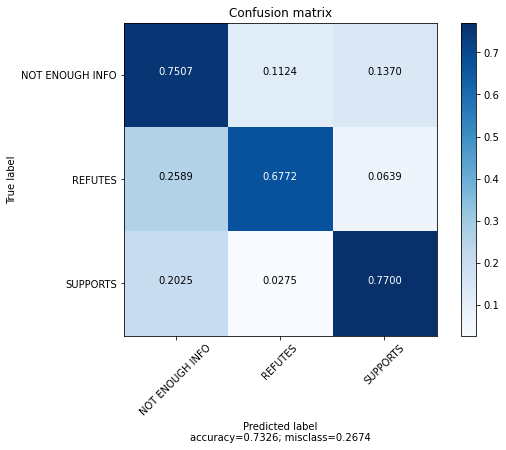

WEIGHTED_SUM2
                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.73      0.68      0.70      6666
        REFUTES       0.81      0.74      0.78      6666
       SUPPORTS       0.76      0.88      0.82      6666

       accuracy                           0.77     19998
      macro avg       0.77      0.77      0.76     19998
   weighted avg       0.77      0.77      0.76     19998



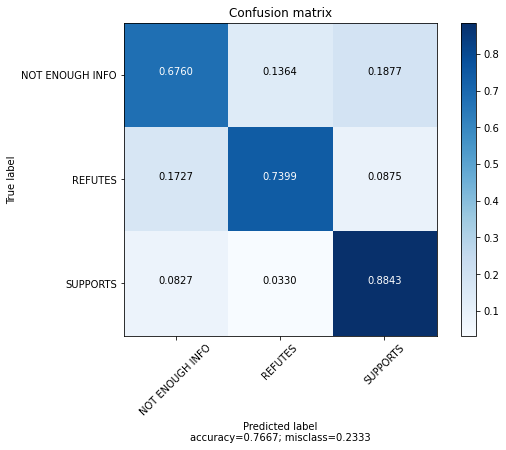

MALON
                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.73      0.68      0.70      6666
        REFUTES       0.82      0.71      0.76      6666
       SUPPORTS       0.74      0.89      0.81      6666

       accuracy                           0.76     19998
      macro avg       0.76      0.76      0.76     19998
   weighted avg       0.76      0.76      0.76     19998



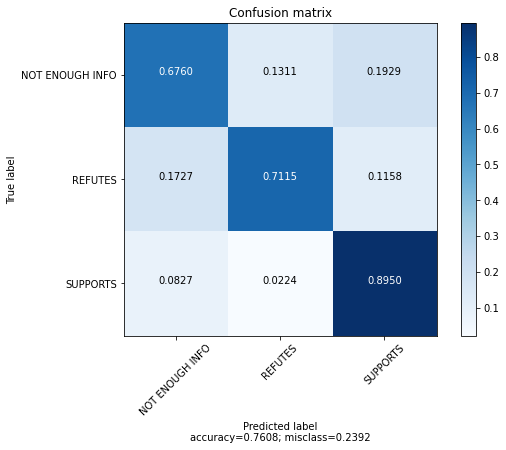

RANKED
                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.73      0.68      0.70      6666
        REFUTES       0.82      0.74      0.78      6666
       SUPPORTS       0.77      0.89      0.82      6666

       accuracy                           0.77     19998
      macro avg       0.77      0.77      0.77     19998
   weighted avg       0.77      0.77      0.77     19998



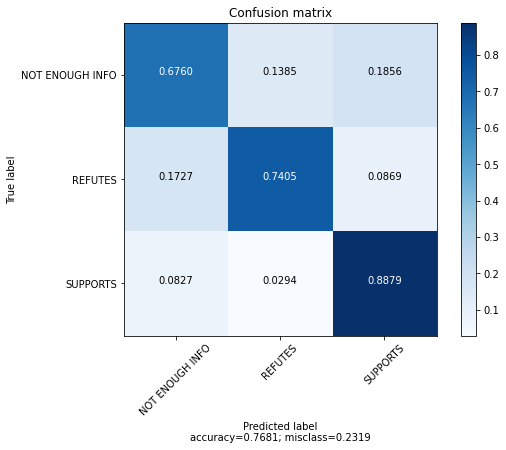

In [244]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

for method in methods:
    print(method.upper())
    cr = classification_report(df_with_evidence_scored['label'], df_with_evidence_scored[f'predicted_label_{method}'])
    print(cr)

    cm = confusion_matrix(df_with_evidence_scored['label'], df_with_evidence_scored[f'predicted_label_{method}'])
    plot_confusion_matrix(cm, ['NOT ENOUGH INFO','REFUTES','SUPPORTS'])

# Calculating FEVER Score for DEV set

In [245]:
from fever.scorer import fever_score

In [246]:
df_with_evidence_scored = df_with_evidence_scored.drop('evidence_golden', axis=1)

SCRATCH = Path('/scratch/users/k2031554')
gold_file = SCRATCH / 'fever/shared_task_dev.jsonl'

gold_data = []
with open(gold_file, 'r') as f:
    for line in f:
        gold_data.append(json.loads(line))
gold_data = pd.DataFrame(gold_data).set_index('id')
df_with_evidence_scored = df_with_evidence_scored.set_index('id').join(gold_data['evidence'], how='outer', rsuffix='_golden').reset_index()
df_with_evidence_scored

,id,evidence,claim,label,predicted_label_WEIGHTED_SUM,predicted_label_MALON,predicted_label_RANKED,predicted_label_WEIGHTED_SUM2,evidence_golden
0,91198,"[[Colin_Kaepernick, 6, He remained the team 's...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,"[[[108548, None, None, None]]]"
1,194462,"[[Tilda_Swinton, 0, Katherine Matilda `` Tilda...",Tilda Swinton is a vegan.,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"[[[227768, None, None, None]]]"
2,137334,"[[Soul_Food_-LRB-film-RRB-, 0, Soul Food is a ...",Fox 2000 Pictures released the film Soul Food.,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,"[[[289914, 283015, Soul_Food_-LRB-film-RRB-, 0..."
3,166626,"[[Anne_Rice, 5, Born in New Orleans , Rice spe...",Anne Rice was born in New Jersey.,NOT ENOUGH INFO,REFUTES,REFUTES,REFUTES,REFUTES,"[[[191656, None, None, None], [191657, None, N..."
4,111897,"[[Telemundo, 0, Telemundo LRB LSB teleˈmundo R...",Telemundo is a English-language television net...,REFUTES,REFUTES,REFUTES,REFUTES,REFUTES,"[[[131371, 146144, Telemundo, 0]], [[131371, 1..."
...,...,...,...,...,...,...,...,...,...
19993,8538,"[[Hermit_crab, 0, Hermit crabs are decapod cru...",Hermit crabs are arachnids.,REFUTES,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,"[[[15450, 19262, Hermit_crab, 0], [15450, 1926..."
19994,145641,"[[Michael_Hutchence, 15, On the morning of 22 ...",Michael Hutchence died on a boat.,REFUTES,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"[[[168967, 182663, Michael_Hutchence, 15]]]"
19995,87517,"[[Cyclades, 0, The Cyclades LRB LSB ˈsɪklədiːz...",The Cyclades are located to the southeast of G...,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,SUPPORTS,"[[[104709, 118125, Cyclades, 0]]]"
19996,111816,"[[Theresa_May, 6, From 1977 until 1983 , she w...",Theresa May worked the docks.,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"[[[131223, None, None, None]]]"


In [247]:
predicted = {}
for method in methods:
    predicted[method] = []
    for idx in df_with_evidence_scored.index:
        #print(df_with_evidence_scored.loc[idx],'\n')
        #print(df_with_evidence_scored.loc[idx], '\n')
        instance = {
            'label': df_with_evidence_scored.loc[idx, 'label'],
            'predicted_label': df_with_evidence_scored.loc[idx, f'predicted_label_{method}'],
            'predicted_evidence': [
                [evidence[0], evidence[1]] for evidence in df_with_evidence_scored.loc[idx, 'evidence']
            ],
            'evidence': df_with_evidence_scored.loc[idx, 'evidence_golden'],
        }
        predicted[method].append(instance)
        
        
        #print(instance)
        #break

In [248]:
for e in predicted['WEIGHTED_SUM']:
    assert e['evidence'] is not  None

In [249]:
for method in methods:
    print(method,'\n')
    strict_score, label_accuracy, precision, recall, f1 = fever_score(predicted[method])

    print('strict_score:',strict_score)    
    print('label_accuracy:',label_accuracy)   
    print('precision:',precision) # It's ok if this is bad. It's recall that matters.       
    print('recall:',recall)           
    print('f1:',f1)     
    print()
#strict_score: 0.7549254925492549
#label_accuracy: 0.7563256325632564
#precision: 0.3059355935593105
#recall: 0.9966246624662466
#f1: 0.46815946710641265



WEIGHTED_SUM 

strict_score: 0.7312731273127313
label_accuracy: 0.7326232623262326
precision: 0.3059355935593105
recall: 0.9966246624662466
f1: 0.46815946710641265

WEIGHTED_SUM2 

strict_score: 0.7652765276527653
label_accuracy: 0.7667266726672667
precision: 0.3059355935593105
recall: 0.9966246624662466
f1: 0.46815946710641265

MALON 

strict_score: 0.7593759375937594
label_accuracy: 0.7608260826082608
precision: 0.3059355935593105
recall: 0.9966246624662466
f1: 0.46815946710641265

RANKED 

strict_score: 0.7666766676667667
label_accuracy: 0.7681268126812681
precision: 0.3059355935593105
recall: 0.9966246624662466
f1: 0.46815946710641265



## Results Comparison Table

- DW = Dev Weighted
- DM = Dev Malon
- SS = Strict Score
- LA = Label Accuracy
- Precision, Recall, and F1 are all partition dependant only and are:
    - 0.3059355935593105, 0.9966246624662466, and 0.46815946710641265, for DEV set    

| Model                    | Specials Encoded | DW SS  | DW LA  | DM SS  | DM LA  |
|--------------------------|------------------|--------|--------|--------|--------|
| BERT_FEVER_v1_model      | N                | 0.5772 | 0.5785 | 0.5866 | 0.5883 |
| BERT_FEVER_v2_model      | N                | 0.6800 | 0.6815 | 0.7380 | 0.7397 |
| BERT_FEVER_v2_model      | Y                | 0.6917 | 0.6931 | 0.7414 | 0.7430 |
| BERT_FEVER_v3_model      | N                | **0.6997** | **0.7009** | 0.7501 | 0.7515 |
| BERT_FEVER_v4_model_ASHA | N                | 0.6955 | 0.6968 | 0.7593 | 0.7608 |
| BERT_FEVER_v4_model_PBT  | N                | 0.6952 | 0.6964 | **0.76110** | **0.7624** |
| BERT_FEVER_2021          | N                | 0.6990 | 0.7003 | **0.7623** | **0.7637** |

For the **DEV** set, we have:
```
WEIGHTED_SUM 

strict_score: 0.6787178717871787 (0.6932693269326933 with SPECIAL_CHARS_CODED)
label_accuracy: 0.6802180218021803
precision: 0.3059355935593105
recall: 0.9966246624662466
f1: 0.46815946710641265

MALON 

strict_score: 0.7377737773777377 (0.7416741674167416 with SPECIAL_CHARS_CODED)
label_accuracy: 0.7394239423942395
precision: 0.3059355935593105
recall: 0.9966246624662466
f1: 0.46815946710641265
```

And for the **EVAL** set (DEV minus the evidence golden data) we have:
```
WEIGHTED_SUM 

strict_score: 0.6674667466746674
label_accuracy: 0.6815681568156816
precision: 0.27134213421338077
recall: 0.9450945094509451
f1: 0.4216314307258454

MALON 

strict_score: 0.712921292129213
label_accuracy: 0.7304730473047305
precision: 0.27134213421338077
recall: 0.9450945094509451
f1: 0.4216314307258454
```
For **TRAIN** (with golden data) we have:
```
WEIGHTED_SUM 

strict_score: 0.7833192390459887
label_accuracy: 0.785436819778754
precision: 0.3213527911850318
recall: 0.9959202258446408
f1: 0.48591558505383614

MALON 

strict_score: 0.8456916169928979
label_accuracy: 0.8481529608316317
precision: 0.3213527911850318
recall: 0.9959202258446408
f1: 0.48591558505383614
```

# Calculating blind score for test set

First, run the cells above but for the TEST set, except for the evaluation cells, as they do not work without the ground-truth labels (The test set does not have any).

In [15]:
for method in methods:

    predicted = []
    for idx in df_with_evidence_scored.index:
        instance = {
            'id': idx,
            'predicted_label': df_with_evidence_scored.loc[idx, f'predicted_label_{method}'],
            'predicted_evidence': [
                [evidence[0], evidence[1]] for evidence in df_with_evidence_scored.loc[idx, 'evidence']
            ]
        }
        predicted.append(instance)
        
    output = f'./data/support_data_v2/blind_submission_bert_test_from_fresh_trained_with_batch_size_32_LABELLED_{method}.jsonl'
    with open(output,'w+') as f:
        for p in predicted:
            f.write(json.dumps(p)+'\n')

References from last year (best model by us, best model by others)

- blind_submission_bert_test_from_fresh_trained_with_batch_size_32_LABELLED
    - FEVER Score: 		0.6739
    - Accuracy: 		0.7037
    - Evidence Precision: 	0.2482
    - Evidence Recall: 	0.87
    - Evidence F1: 		0.3863

- blind_submission_bert_test_LABELLED
    - FEVER Score: 		0.6769
    - Accuracy: 		0.7066
    - Evidence Precision: 	0.2521
    - Evidence Recall: 	0.8747
    - Evidence F1: 		0.3914


For the **TEST** set, we have:
```
WEIGHTED_SUM 

strict_score: 0.617
label_accuracy: 0.6508
precision: 0.2482
recall: 0.87
f1: 0.3863

MALON 

strict_score: 0.6617
label_accuracy: 0.6912
precision: 0.2482
recall: 0.87
f1: 0.3863
```